# Invertir un vector con seq2seq with attention

In [1]:
import numpy  as np 
import matplotlib.pyplot as plt 
import torch
from torch import nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset,Dataset, DataLoader, random_split, IterableDataset
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import ExponentialLR
import gc
import math


In [93]:
#implementacion de un seq2seq con atencion

class EncoderRNN(nn.Module):
    #esto nos va a devolver un output y un hidden state
    #tenemos tambien un init_hidden para inicializar el hidden state
    #nos interesa el tamaño del input y del hidden state (el output tiene tamaño del hidden)
    def __init__(self,d_input,d_hidden):
        super().__init__()
        self.d_input=d_input
        self.d_hidden=d_hidden
        #vamos a crear un embeding propio con una densa antes de la RNN 
        self.relu=nn.ReLU()
        self.dense1=nn.Linear(d_input,d_hidden)
        self.rnn=nn.GRU(d_hidden,d_hidden,batch_first=True) #como no ponemos batch_first=True todo sera de dimension dim: len x hidden size

    def forward(self,x,hidden):
        x=self.relu(self.dense1(x)) # pasamos B x 1 x input y obtenemos B x 1 x hidden_dim
        output,hidden_out=self.rnn(x,hidden) #obtenemos B x 1 x hidden_dim y 1 x B x hidden_dim 
        return output,hidden_out #obtenemos B x len_seq x hidden_dim y 1 x B x hidden_dim
    
    def init_hidden(self,batch_size=1):
        return torch.zeros(1,batch_size,self.d_hidden)


In [7]:
#provemos lo anterior
encoder=EncoderRNN(1,15)
test_vector=torch.randn(5,1,1)
output,attn=encoder(test_vector,encoder.init_hidden(5))
print(output.shape,attn.shape)

torch.Size([5, 1, 15]) torch.Size([1, 5, 15])


In [8]:
class Attention(nn.Module):
    #este es el mecanismo de atencion, el dot product basicamente
    def __init__(self):
        super().__init__()


    def forward(self,hidden_state,encoder_outputs):
        #si el encoder_outputs es:  Batch x len_seq x hidden_dim y el hidden state que usamo de Q es 1 x B x Hidden_dim, devolvemos un context que es B x 1 x hidden_dim  y attn_weights B x 1 x len_seq

        #transponemos el hidden state para hacer las multiplicaciones sobre los batches

        hidden_state_transpose=hidden_state.transpose(0,1) # ahora es B x 1 x hidden
        #el objetivo es multiplicarlo por el encoder_outputs que es  Batch x len_seq x hidden_dim, y para ello lo tenemos que transponer
        encoder_outputs_transpose=encoder_outputs.transpose(1,2) # Batch x  hidden_dim x len_seq 
        #aqui calculamos el alignement

        e=torch.bmm(hidden_state_transpose,encoder_outputs_transpose) # B x 1 x len_seq
        att_weights=F.softmax(e,dim=2) # B x 1 x len_seq y suman 1 sobre los elementos en esa dimension
        context=torch.bmm(att_weights,encoder_outputs) # hacemos la multiplicacion para obtener B x 1 x hidden_dim
        return context, att_weights # return  B x 1 x hidden_dim y B x 1 x len_seq 




In [11]:
attn=Attention()
emb_outs=torch.ones(2,7,15)
emb_outs[:,3:4,:]=1
context,attn=attn(torch.ones(1,2,15),emb_outs)
attn

tensor([[[0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429]],

        [[0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429]]])

In [304]:
class DecoderRNN(nn.Module):
    #este decoder va a tener implementada la atencion
    #empezaremos el decoder con un hidden_state 0 igual que antes
    #el hidden state previo se le va a meter a modo de query al modelo de atencion, que va a recibir tambien los values, que 
    #son los estados hidden del encoder, de modo que lo ejecutamos en el init de aqui, el encoder
    def __init__(self,input_dim,hidden_size):
        super().__init__()
        self.d_input=input_dim
        self.d_output=input_dim
        self.d_hidden=hidden_size
        #un enmbeding para el input y una densa para el output
        self.dense_in=nn.Linear(input_dim,hidden_size)
        self.dense_out1=nn.Linear(hidden_size*2,hidden_size)
        self.dense_out2=nn.Linear(hidden_size,input_dim) # asumienod dim_input = dim_output

        self.rnn=nn.GRU(hidden_size,hidden_size,batch_first=True)#como no ponemos batch_first=True todo sera de dimension dim: len x hidden size

        #el mecanismo de atencion y los hidden states del encoder
        self.attn=Attention()

    def forward(self,prev_input,hidden_state,encoder_outputs):
        #hacer forward de esto es partiendo del hidden state anterior, sacar el nuevo
        #y con ese calcular la atencion y el context vector, y luego juntarlo con el hidden state y meterlo en la dense y obtener el nuedo hidden

        #el input debe de pasar por el embeding
        x=F.relu(self.dense_in(prev_input)) # entra B x 1 x input_dim y sale B x 1 x Hidden_dim, el 1 es porque estamos procesando un tocken solo
        #ahora calculamos el hidden state
        _,new_hidden_state=self.rnn(x,hidden_state) #entran y_(t-1)=B x 1 x Hidden_dim y h_(t-1)= 1 x Batch_size x Hidden_dim y salen y_t = B x 1 x Hidden_dim y h_t = 1 x B x Hidden_dim

        #con este hidden state,calculamos la attencion, se calcula en cada dimension batch independiente
        #si el encoder_outputs es:  Batch xlen_seq x hidden_dim y el hidden state que usamo de Q es 1 x B x Hidden_dim, devolvemos un context que es B x 1 x hidden_dim  y attn_weights B x 1 x len_seq
        context,attn_weigths=self.attn(new_hidden_state,encoder_outputs) # return  B x 1 x hidden_dim y B x 1 x len_seq 
        new_hidden_state_transpose=new_hidden_state.transpose(0,1)
        #con este context y con el hiden state creamos un vector para meter en una dense
        #out=self.dense_out1(torch.cat((new_hidden_state_transpose,context),dim=2))# le metemos B x 1 x 2*hidden_dim y sacamos B x 1 x hidden_dim
        out1=self.dense_out2(context) #metemos B x 1 x hidden_dim y sacamos B x 1 x input_dim

        return out1,new_hidden_state, attn_weigths #B x 1 x input_dim , 1 x B x Hidden_dim y B x 1 x len_seq
    
    def init_hidden(self,batch_size=1):
        return torch.zeros(1,batch_size,self.d_hidden)

In [34]:
decoder=DecoderRNN(1,15)

a=torch.zeros(2,7,15)
a[:,[2],:]=1
o,h,atn=decoder(torch.randn(2,1,1),torch.randn(1,2,15),a)

In [40]:
class DataFlip(Dataset):
    def __init__(self,seq_len,input_dim,max_dim):
        super().__init__()
        self.seq_len=seq_len
        self.input_dim=input_dim
        self.max_dim=max_dim

    def __getitem__(self, index):
        x=torch.randint(0,50,(self.seq_len,self.input_dim)).float()
        y=x.flip(1)
        return x,y
    def __len__(self):
        return self.max_dim

In [19]:
a=torch.randn(1,4,1)
print(a,a.flip(1)
)

tensor([[[-1.2476],
         [-0.4090],
         [-1.2719],
         [ 2.5491]]]) tensor([[[ 2.5491],
         [-1.2719],
         [-0.4090],
         [-1.2476]]])


In [38]:
# el entrenamiento
def train(train_dataloader,encoder, decoder, init_decoder_state,optim_encoder,optim_decoder,epochs,):
    #primero inicializamos todo


    #bucle de epocas
    for epoch in range(epochs):
        #para cada epoca recorremos todos los batches

        for i,(x_train,y_train) in enumerate(train_dataloader):

            batch_size,len_seq,input_dim=x_train.size()

            #para cada batch de datos, actualizamos los pesos 
            loss=torch.tensor(0)
            optim_encoder.zero_grad()
            optim_decoder.zero_grad()


            list_encoder_hidden_states=torch.zeros(batch_size,len_seq,input_dim)
            hidden_state_encoder=encoder.init_hidden(batch_size)

            #y esto tiene dos fases, la obtener los estados del encoder, y la de procesarlo por el decoder
            for j in range(len_seq):
                input_aux=x_train[:,j,:]
                #calculamoss los estados ocultos de cada instante
                _,hidden_state_encoder=encoder(input_aux,hidden_state_encoder)
                list_encoder_hidden_states[:,[j],:]=hidden_state_encoder


tensor([[[ 0.7764,  0.2985,  0.9831, -0.0340, -0.4747,  0.5859,  0.5646,
          -0.3377,  0.0232, -1.2997, -0.1950, -0.4325,  0.4108,  0.7329,
           0.5236],
         [ 0.0895, -0.4322, -0.8604, -0.4994,  0.2019, -0.3698,  0.3595,
           0.5239,  0.1578,  0.3372,  0.0829,  1.3714,  0.4039,  1.0230,
           0.5676]]], grad_fn=<StackBackward0>)


In [68]:
dataset=DataFlip(7,1,200)
dataloader=DataLoader(dataset,batch_size=32)
x_train,y_train=next(iter(dataloader))
print(x_train.shape,y_train.shape)

hidden_dim=15
encoder=EncoderRNN(1,hidden_dim)
decoder=DecoderRNN(1,hidden_dim)


batch_size,len_seq,input_dim=x_train.size()

#para cada batch de datos, actualizamos los pesos 
loss=torch.tensor(0)

hidden_state_encoder=encoder.init_hidden(batch_size)

#y esto tiene dos fases, la obtener los estados del encoder, y la de procesarlo por el decoder

#calculamoss los estados ocultos de cada instante
list_encoder_hidden_states,_=encoder(x_train,hidden_state_encoder)
hidden_state_encoder_transposed=hidden_state_encoder.transpose(0,1)
list_encoder_hidden_states[:,j,:]=hidden_state_encoder


#y ahora el proceso de prediccion
input_decoder=torch.torch() #aqui ponemos el token input
hidden_state_decoder=decoder.init_hidden(batch_size)

for j in range(len_seq):


    out1,new_hidden_state, attn_weigths=decoder(input_decoder,hidden_state_decoder,list_encoder_hidden_states)
    #tras aplicar


torch.Size([32, 7, 1]) torch.Size([32, 7, 1])


'\n#y ahora el proceso de prediccion\ninput_decoder=torch.torch() #aqui ponemos el token input\nhidden_state_decoder=decoder.init_hidden(batch_size)\n\nfor j in range(len_seq):\n\n\n    out1,new_hidden_state, attn_weigths=decoder(input_decoder,hidden_state_decoder,list_encoder_hidden_states)\n    #tras aplicar\n'

In [253]:
dataset=DataFlip(7,1,200)
dataloader=DataLoader(dataset,batch_size=32)

hidden_dim=15
encoder=EncoderRNN(1,hidden_dim)
decoder=DecoderRNN(1,hidden_dim)

optim_enc=optim.Adam(encoder.parameters())
optim_dec=optim.Adam(decoder.parameters())


batch_size,len_seq,input_dim=x_train.size()
for i in range(13):

    #para cada batch de datos, actualizamos los pesos 
    loss=torch.tensor(0)

    hidden_state_encoder=encoder.init_hidden(batch_size)

    #y esto tiene dos fases, la obtener los estados del encoder, y la de procesarlo por el decoder

    #calculamoss los estados ocultos de cada instante
    list_encoder_hidden_states,_=encoder(x_train,hidden_state_encoder)

    prev_input=torch.ones(batch_size,1,input_dim)*-1.0
    result=[]
    for i in range(7):
        out1,new_hidden_state, attn_weigths=decoder(prev_input,hidden_state_encoder,list_encoder_hidden_states)
        prev_input=out1
        result.append(out1.detach().numpy().squeeze(-1))
        print(out1.shape)

    result=np.array(result).squeeze(-1).swapaxes(0,1)
    print(result.shape)

torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
(8, 7)
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
(8, 7)
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
(8, 7)
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
(8, 7)
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
(8, 7)
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
torch.Size([8, 1, 1])
(8, 7)
torch.Size([8, 1, 1])
torch.Size([

In [306]:
dataset=DataFlip(7,1,32*40)
dataloader=DataLoader(dataset,batch_size=32)
x_train,y_train=next(iter(dataloader))

hidden_dim=15
encoder=EncoderRNN(1,hidden_dim)
decoder=DecoderRNN(1,hidden_dim)

optim_enc=optim.Adam(encoder.parameters(),lr=0.001)
optim_dec=optim.Adam(decoder.parameters(),lr=0.001)
loss_criterion=nn.MSELoss()

batch_size,len_seq,input_dim=x_train.size()


In [307]:
for epoca in range(200):
    total_loss=0
    for j,(x_train,y_train) in enumerate(dataloader):
        optim_dec.zero_grad()
        optim_enc.zero_grad()
        #para cada batch de datos, actualizamos los pesos 
        loss=torch.tensor(0.0)
        
        hidden_state_encoder=encoder.init_hidden(batch_size)

        #y esto tiene dos fases, la obtener los estados del encoder, y la de procesarlo por el decoder

        #calculamoss los estados ocultos de cada instante
        list_encoder_hidden_states,last_encoder_hidden=encoder(x_train,hidden_state_encoder)

        prev_input=torch.ones(batch_size,1,input_dim)*-1.0

        result=[]
        for i in range(7):
            out1,new_hidden_state, attn_weigths=decoder(prev_input,last_encoder_hidden,list_encoder_hidden_states)
            last_encoder_hidden=new_hidden_state
            prev_input=y_train[:,[i]]
            result.append(out1)
            loss+=loss_criterion(out1,y_train[:,[i]])
        result2=torch.cat(result,dim=-2)
        loss.backward()
        optim_dec.step()
        optim_enc.step()
        total_loss+=loss.item()
    print(epoca,total_loss)


0 209610.3427734375
1 192321.716796875
2 175830.59057617188
3 176296.1962890625
4 163382.841796875
5 154274.96533203125
6 152983.55493164062
7 141264.06396484375
8 133460.99145507812
9 132570.58520507812
10 127675.125
11 120682.82153320312
12 115584.0439453125
13 111789.74291992188
14 111465.60961914062
15 104764.48510742188
16 100888.92602539062
17 100310.55737304688
18 95794.86584472656
19 93890.21459960938
20 87806.16967773438
21 85426.93603515625
22 84183.86267089844
23 80753.48034667969
24 79616.46704101562
25 78753.96301269531
26 76904.23901367188
27 74308.78601074219
28 74126.646484375
29 72410.24536132812
30 70906.36987304688
31 68982.98083496094
32 68674.54858398438
33 67154.53723144531
34 65322.45056152344
35 65828.6845703125
36 65797.76647949219
37 63149.86340332031
38 62051.468994140625
39 61626.66455078125
40 60830.54150390625
41 61425.84802246094
42 61757.26416015625
43 60232.4873046875
44 61155.92126464844
45 60602.77770996094
46 59451.576171875
47 59451.63342285156
48 6

In [298]:
dataset=DataFlip(7,1,32*2)
dataloader=DataLoader(dataset,batch_size=32)
x_train,y_train=next(iter(dataloader))

#para cada batch de datos, actualizamos los pesos 
loss=torch.tensor(0.0)

hidden_state_encoder=encoder.init_hidden(batch_size)

#y esto tiene dos fases, la obtener los estados del encoder, y la de procesarlo por el decoder

#calculamoss los estados ocultos de cada instante
list_encoder_hidden_states,last_encoder_hidden=encoder(x_train,hidden_state_encoder)

prev_input=torch.ones(batch_size,1,input_dim)*-1.0

result=[]
attn=[]
for i in range(7):
    out1,new_hidden_state, attn_weigths=decoder(prev_input,last_encoder_hidden,list_encoder_hidden_states)
    last_encoder_hidden=new_hidden_state
    prev_input=out1
    result.append(out1)
    attn.append(attn_weigths)
    loss+=loss_criterion(out1,y_train[:,[i]])
result2=torch.cat(result,dim=-2)
atten=torch.cat(attn,dim=-2)


In [300]:
atten[1].detach().numpy().round(1)

array([[0.4, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.3, 0.5, 0.1, 0. , 0. , 0. , 0. ],
       [0.3, 0.5, 0.1, 0. , 0. , 0. , 0. ],
       [0.2, 0.4, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.2, 0. , 0.1, 0.1, 0.3, 0.2],
       [0. , 0.1, 0. , 0.1, 0.2, 0.3, 0.3],
       [0. , 0.1, 0. , 0.1, 0.2, 0.3, 0.3]], dtype=float32)

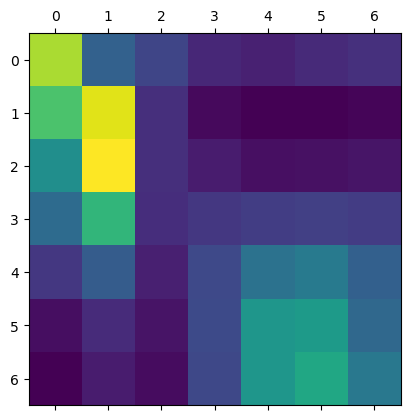

In [301]:
plt.matshow(atten[9].detach().numpy())

In [303]:
print(torch.cat([result2[2],y_train[2]],dim=-1))

tensor([[15.1777, 12.0000],
        [36.3473, 47.0000],
        [21.0382,  5.0000],
        [20.1178, 39.0000],
        [13.9750,  3.0000],
        [21.8302, 30.0000],
        [28.7812, 33.0000]], grad_fn=<CatBackward0>)


In [81]:
#vamos a probar como funciona la GRU y el output y tal
RNN=nn.GRU(15,3,batch_first=True)
x_test=torch.randint(0,100,(5,7,15)).float()
hidden_state_encoder=torch.ones(1,5,3)
list_encoder_hidden_states=torch.zeros(7,5,3)
for j in range(7):
    input_aux=x_test[:,[j],:]
    #calculamoss los estados ocultos de cada instante
    _,hidden_state_encoder=RNN(input_aux,hidden_state_encoder)
    list_encoder_hidden_states[j]=hidden_state_encoder

output_total,_=RNN(x_test,torch.ones(1,5,3))
print(list_encoder_hidden_states.shape,output_total.shape,torch.all(list_encoder_hidden_states==output_total.transpose(0,1)))


torch.Size([7, 5, 3]) torch.Size([5, 7, 3]) tensor(True)
